# Generating the synthetic stations and their apparatus assignments

In [ ]:
import pandas as pd
assignment_cols = ['StationID', 'Engine', 'Truck', 'Rescue', 'Hazard', 'Squad', 'FAST', 'Medic', 'Brush', 'Boat', 'UTV', 'REACH']
station_cols = ['StationID', 'Facility Name', 'Address', 'City', 'State', 'Zip Code', 'GLOBALID', 'lat', 'lon']
sdf = pd.read_csv("/Users/jose/Developer/git/fire_simulator/data/stations.csv")
sdf.loc[sdf['Facility Name'] == 'Station 41 / Goodlettesville', 'Facility Name'] = 'Station 41'
sdf['StationID'] = sdf['Facility Name'].str.split(' ').str[1]
sdf = sdf[station_cols]
sdf['StationID'] = sdf['StationID'].astype('int')
sdf = sdf.sort_values(by='StationID')
sdf = sdf.reset_index(drop=True)
sdf['StationID'] = sdf.index
sdf.head()
assignments = []
for k, v in sdf.iterrows():
    values = [v['StationID']] + [2] + [0] * (len(assignment_cols) - 2)
    assignments.append(values)
adf = pd.DataFrame(assignments, columns=assignment_cols)
adf.to_csv("./data/assignments.csv", index=False)
sdf.to_csv("./data/stations.csv", index=False)

<Axes: >

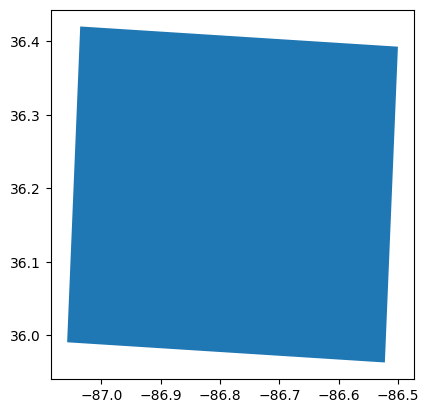

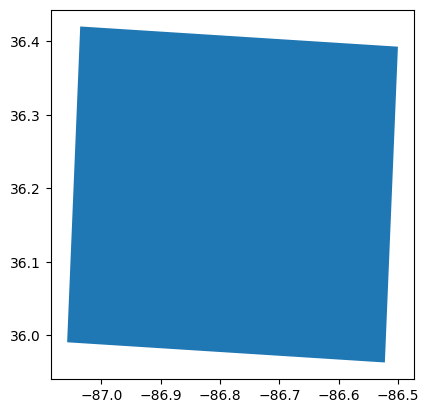

In [ ]:
import geopandas as gpd
# Get actual bounds of the city.
df = gpd.read_file("data/bounds.geojson")
df.plot()
df.minimum_rotated_rectangle().to_file("data/bounds_mrr.geojson", driver="GeoJSON")
df.plot()

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
stations = pd.read_csv("data/stations.csv")
incidents = pd.read_csv("data/incidents.csv")
# plot the two dataframes on a map
stations_gdf = gpd.GeoDataFrame(
    stations, geometry=gpd.points_from_xy(stations.lon, stations.lat), crs="EPSG:4326"
)
incidents_gdf = gpd.GeoDataFrame(
    incidents, geometry=gpd.points_from_xy(incidents.lon, incidents.lat), crs="EPSG:4326"
)
fig, ax = plt.subplots(figsize=(10, 10))
stations_gdf.plot(ax=ax, color='blue', markersize=5, label='Stations')
incidents_gdf.plot(ax=ax, color='red', markersize=5, label='Incidents')
# add the station and incident labels
for x, y, label in zip(stations_gdf.geometry.x, stations_gdf.geometry.y, stations_gdf['StationID']):
    ax.text(x, y, label, fontsize=8, ha='right', va='bottom', color='blue')
for x, y, label in zip(incidents_gdf.geometry.x, incidents_gdf.geometry.y, incidents_gdf['incident_id']):
    ax.text(x, y, label, fontsize=8, ha='right', va='bottom', color='red')
plt.legend()
plt.title('Fire Stations and Incidents')

FileNotFoundError: [Errno 2] No such file or directory: 'data/incidents.csv'

In [ ]:
import pandas as pd
date_range = pd.date_range(start="2022-01-01", end="2022-12-31", freq='1D')
# 325002//len(date_range), len(date_range)
PER_DAY = 314
COUNT = PER_DAY * len(date_range)
COUNT

# Generating synthetic incident data

In [ ]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import random
import requests
from pandas import to_datetime, Timedelta

def generate_random_points_within_bounds(bounds, num_points):
    minx, miny, maxx, maxy = bounds.bounds
    points = []
    for _ in range(num_points):
        epsilon = 1e-8  # A very small value
        x = random.uniform(minx + epsilon, maxx - epsilon)
        y = random.uniform(miny + epsilon, maxy - epsilon)
        points.append(Point(x, y))
    return points

def get_nearest_lat_lon(point, osrm_url):
    response = requests.get(f"{osrm_url}/nearest/v1/driving/{point.x},{point.y}")
    if response.status_code == 200:
        data = response.json()
        if data['waypoints']:
            return data['waypoints'][0]['location']
    return None

def generate_incidents(num_incidents, incident_types, incident_levels, date_range, nearest_points):
    incidents = []
    for idx in range(num_incidents):
        incident_type = random.choice(incident_types)
        incident_level = random.choice(incident_levels)
        date_time = random.choice(date_range)
        lon, lat = random.choice(nearest_points)
        incidents.append({
            "incident_id": f"{idx}",
            "lat": lat,
            "lon": lon,
            "incident_type": incident_type,
            "incident_level": incident_level,
            "datetime": date_time,
        })
    return pd.DataFrame(incidents)

osrm_url = "http://localhost:8085"
num_incidents = 400
nearest_points = []

# Get actual bounds of the city.
df = gpd.read_file("data/bounds.geojson")
# Generate random points within the bounds.
random_points = generate_random_points_within_bounds(df.unary_union, num_incidents)
# for each point, query the nearest lat lon on the street network with osrm
for point in random_points:
    nearest = get_nearest_lat_lon(point, osrm_url)
    if nearest:
        nearest_points.append(nearest)

incident_types = ["Fire"]
incident_levels = ["Low", "Moderate", "High", "Critical"]
# date_range = pd.date_range(start="2022-01-01", end="2024-10-29", freq='1T')
date_range = pd.date_range(start="2022-01-01", end="2022-01-02", freq='5T')

incidents_df = generate_incidents(num_incidents, incident_types, incident_levels, date_range, nearest_points)
incidents_df = incidents_df.sort_values(by='datetime')
incidents_df = incidents_df.reset_index(drop=True)
incidents_df['incident_id'] = incidents_df.index


# Ensure datetime is in datetime format and sorted

seen = set()
for idx, row in incidents_df.iterrows():
    dt = row['datetime']
    # Increment by 1 minute until unique
    while dt in seen:
        dt += Timedelta(minutes=1)
    incidents_df.at[idx, 'datetime'] = dt
    seen.add(dt)

incidents_df['datetime'] = pd.to_datetime(incidents_df['datetime'])
incidents_df = incidents_df.sort_values('datetime').reset_index(drop=True)
incidents_df.to_csv("data/incidents.csv", index=False)

# Plotting the differences between different OSRM instances
* One is turning off wrong way driving

In [ ]:
# Given this url: http://localhost:8080/route/v1/driving/-86.7816,36.1627;-86.7679,36.1745?overview=full&geometries=geojson
# plot the route on the map.
import requests
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import shape

def plot_route(osrm_url, start, end):
    response = requests.get(f"{osrm_url}/route/v1/driving/{start[0]},{start[1]};{end[0]},{end[1]}?overview=full&geometries=geojson")
    if response.status_code == 200:
        data = response.json()
        if data['routes']:
            route_geojson = data['routes'][0]['geometry']
            route_shape = shape(route_geojson)
            route_gdf = gpd.GeoDataFrame(geometry=[route_shape], crs="EPSG:4326")
            return route_gdf
    return None

# Normal car version
osrm_url = "http://localhost:8080"

start = (-86.7816, 36.1627)
end = (-86.7679, 36.1745)

route_gdf = plot_route(osrm_url, start, end)

fig, ax = plt.subplots()
if route_gdf is not None:
    route_gdf.plot(ax=ax, color='blue', linewidth=5, label='CAR')

# EMS version
osrm_url = "http://localhost:8085"

start = (-86.7816, 36.1627)
end = (-86.7679, 36.1745)

route_gdf = plot_route(osrm_url, start, end)

if route_gdf is not None:
    route_gdf.plot(ax=ax, color='red', linewidth=2, label='EMS')
    ax.set_title("Route from Start to End")

ctx.add_basemap(ax, crs=route_gdf.crs.to_string())
plt.legend()
plt.show()


# Cleaning and Preparing the Zones geojson
* Split multipolygons into separate polygons, but keep the names and zones.

In [43]:

import geopandas as gpd
import os
import pandas as pd
from shapely.geometry import Point
import re

def split_string(s):
    match = re.match(r'^(\d+)(.*)$', s)
    if match:
        number = int(match.group(1))
        suffix = match.group(2) if match.group(2) else None
        return number, suffix
    else:
        raise ValueError(f"Invalid input: {s}")

# Suppose 'union_polygon' may be a MultiPolygon or Polygon
def split_to_polygons(geom):
    if geom.geom_type == 'MultiPolygon':
        return list(geom.geoms)
    elif geom.geom_type == 'Polygon':
        return [geom]
    else:
        return []

# Setting up the beats matrix
* Requires the FIRE RUN CARDS OCT 2024 folder to be present.
* Fire run cards directory should have files named:
    * Beat-ZONE.xlsx

In [44]:
import geopandas as gpd
import pandas as pd
import os

In [45]:
stations_df = pd.read_csv("data/stations.csv")
stations_df.head(1)

,StationID,Facility Name,Address,City,State,Zip Code,GLOBALID,lat,lon
0,0,Station 01,130 Broadmoor Ave,Nashville,TN,37207,fa10573a-b069-4f65-9663-0c4ecc4e2b0d,36.22939,-86.756748


In [46]:
df = gpd.read_file("data/FireBeats_shapefile_05152025")
zones = df['NAME'].unique()
zones = sorted(zones)
zones[1:5]

# What are these names and what do they correspond to?
ignored_names = [
    "FD/RADIO",
    "FD/FST11",
    "FD/FST06",
    "FD/FST09",
    "FD/FST37",
    "FD/FAST01",
    "FD/SQ01",
    "FD/SQ37",
    "FD/SQ09",
    "FD/SQ11",
    "FD/TC05",
    "FD/DS31",
    "FD/MED41",
    "FD/HQ",
    "FD/BAR*",
    "FD/DSOP",
    "FD/BT13", "FD/BT22", "FD/BT35", "FD/BT36"
]

In [47]:
# Read the Excel file and specify the sheet name (or use sheet number)
excel_path = "data/FIRE RUN CARDS OCT 2024/"
sheet_name = "RunCardOrder"  # Change to your actual sheet name

beats = []
max_runs = 0
for zone_name in zones:

    i_name, s_name = split_string(zone_name)
    # print(i_name, s_name)
    if s_name is not None:
        new_name = f"{str(i_name).zfill(2)}{s_name}"
    else:
        new_name = str(i_name).zfill(2)
    # Construct the full path to the Excel file for the specific zone
    excel_path = f"data/FIRE RUN CARDS OCT 2024/BEAT-{new_name}.xlsx"
    
    # Check if the file exists before proceeding
    if not os.path.exists(excel_path):
        print(f"File {excel_path} does not exist. Skipping.")
        continue
    
    # Read the sheet into a DataFrame
    df = pd.read_excel(excel_path, sheet_name=sheet_name)
    # Confirm these with Fire Department
    df = df[~df['OrderValue'].isin(ignored_names)]
    df = df[~df['OrderValue'].str.contains("FST")]
    df = df[~df['OrderValue'].str.contains("FB")]
    df = df[~df['OrderValue'].str.contains("SQ")]
    df = df[~df['OrderValue'].str.contains("MED")]
    df = df[~df['OrderValue'].str.contains("BT")]
    df = df[~df['OrderValue'].str.contains("DSOP")]
    df = df[~df['OrderValue'].str.contains("RADIO")]
    df = df[~df['OrderValue'].str.contains("HQ")]
    df = df[~df['OrderValue'].str.contains("EN")]
    df = df[~df['OrderValue'].str.contains("RE")]
    df = df[~df['OrderValue'].str.contains("ATV")]
    df = df[~df['OrderValue'].str.contains("TC")]
    df = df[~df['OrderValue'].str.contains("BAR")]
    df['Facility Name'] = df['OrderValue'].str.split('/').str[1]
    try:
        df['Facility Name'] = df['Facility Name'].str.replace('S', 'Station ')
        df['StationID'] = df['Facility Name'].str.split(' ').str[1]
        df['StationID'] = df['StationID'].astype('int')
        df['Facility Name'] = 'Station ' + df['StationID'].astype(str).str.zfill(2)
        df.drop(columns=['StationID'], inplace=True)
    except Exception as e:
        print(new_name, e)
        # display(df.head())

    max_runs = max(max_runs, df['OrderValue'].shape[0])
    run_order = df['Facility Name'].tolist()
    if len(run_order) < max_runs:
        run_order += ["None"] * (max_runs - len(run_order))
    run_order = [new_name] + run_order
    beats.append(run_order)
df = pd.DataFrame(beats, columns=['Zone'] + [f'Run {i+1}' for i in range(max_runs)])
# replace all '' in df with 'None'
df = df.replace('', 'None')
df = df.fillna('None')
for i in range(len(beats)):
    # print(beats[i])
    if len(beats[i]) < max_runs:
        beats[i] += ["None"] * (max_runs - len(beats[i]))
    # print(len(beats[i]))
df.to_csv("data/beats.csv", index=False)

In [48]:
# map the values in df to StationID in stations df. so Station 01 becomes 0, Station 02 becomes 1, etc.
# 1. Create a mapping from facility name to StationID
station_map = dict(zip(stations_df['Facility Name'], stations_df['StationID']))
station_map['Station 02'] = 1 # Station 2 merged with 3

# 2. Replace all station names in df (except for the 'Zone' column)
df.iloc[:, 1:] = df.iloc[:, 1:].replace(station_map)
df.replace('None', -1, inplace=True)
df = df.reset_index(drop=False)
zones_df = df[["index", "Zone"]].copy()
zones_df.rename(columns={"index": "ZoneID", "Zone":"Zone Name"}, inplace=True)
zones_df.to_csv("data/zones.csv", index=False)
zones_df.head(1)

/var/folders/dn/4tl8dq2j1kjg_kr415l1f6_w0000gp/T/ipykernel_60019/1044239265.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.iloc[:, 1:] = df.iloc[:, 1:].replace(station_map)
/var/folders/dn/4tl8dq2j1kjg_kr415l1f6_w0000gp/T/ipykernel_60019/1044239265.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace('None', -1, inplace=True)


,ZoneID,Zone Name
0,0,01


In [49]:
df.head()

,index,Zone,Run 1,Run 2,Run 3,Run 4,Run 5,Run 6,Run 7,Run 8,...,Run 32,Run 33,Run 34,Run 35,Run 36,Run 37,Run 38,Run 39,Run 40,Run 41
0,0,01,0,23,1,27,16,37,29,20,...,4,24,38,30,31,33,35,32,-1,-1
1,1,10,8,25,18,4,24,19,3,6,...,23,22,38,30,34,36,29,37,28,-1
2,2,10A,8,25,18,4,24,19,3,6,...,23,22,38,30,34,36,29,37,28,-1
3,3,10B,8,4,24,25,2,31,33,19,...,23,22,38,30,34,36,29,37,28,-1
4,4,10C,8,4,25,24,2,19,31,13,...,27,20,38,30,34,36,29,37,28,-1


In [50]:
# show all columns and rows
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', 10)
zones_df

,ZoneID,Zone Name
0,0,01
1,1,10
2,2,10A
3,3,10B
4,4,10C
...,...,...
326,326,09D
327,327,09E
328,328,09F
329,329,09G


In [51]:
zones_to_stations_df = df.drop(columns=["Zone", "index"], errors='ignore')
zones_to_stations_df = zones_to_stations_df.T
display(zones_to_stations_df)

,0,1,2,3,4,5,6,7,8,9,...,321,322,323,324,325,326,327,328,329,330
Run 1,0,8,8,8,8,8,8,8,9,9,...,6,6,7,7,7,7,7,12,7,7
Run 2,23,25,25,4,4,4,4,25,1,11,...,3,3,3,10,3,3,3,7,10,3
Run 3,1,18,18,24,25,24,25,4,22,17,...,14,19,10,3,6,6,6,3,3,12
Run 4,27,4,4,25,24,25,24,24,17,22,...,7,10,6,6,17,10,17,1,6,1
Run 5,16,24,24,2,2,31,2,19,11,1,...,17,14,1,19,14,17,10,16,19,16
Run 6,37,19,19,31,19,33,19,2,1,21,...,18,18,12,17,10,19,14,10,26,10
Run 7,29,3,3,33,31,2,31,13,7,7,...,15,7,17,1,19,1,19,0,13,0
Run 8,20,6,6,19,13,19,33,31,23,1,...,11,17,14,12,1,12,1,27,2,27
Run 9,22,14,14,13,33,13,13,33,21,23,...,19,25,19,26,9,9,12,6,17,6
Run 10,12,2,2,10,10,10,10,18,15,3,...,1,15,9,13,12,16,9,23,14,23


In [52]:
import struct
import numpy as np

# Save to binary file
def save_array_to_binary(filename, array):
    height, width = array.shape
    with open(filename, 'wb') as f:
        # Write width and height as 32-bit integers
        f.write(struct.pack('ii', width, height))
        # Flatten array in row-major order and write the data
        f.write(array.astype(np.int32).tobytes(order='C'))

# Usage

def save_string_matrix(filename, matrix):
    with open(filename, "wb") as f:
        height = len(matrix)
        width = len(matrix[0]) if height > 0 else 0
        f.write(struct.pack("ii", width, height))

        for row in matrix:
            for s in row:
                s_bytes = s.encode("utf-8")
                f.write(struct.pack("i", len(s_bytes)))
                f.write(s_bytes)
# for strings
# matrix = df.to_numpy().tolist()
# save_string_matrix("logs/beats.bin", matrix)

# for integers
print(zones_to_stations_df.to_numpy().shape)
arr = zones_to_stations_df.to_numpy().astype(np.int32)

save_array_to_binary("logs/beats.bin", arr)

(41, 331)


In [53]:
# save numpy array to csv
def save_array_to_csv(filename, array):
    df = pd.DataFrame(array)
    df.to_csv(filename, index=False)
    return df
df = save_array_to_csv("test.csv", arr)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,321,322,323,324,325,326,327,328,329,330
0,0,8,8,8,8,8,8,8,9,9,...,6,6,7,7,7,7,7,12,7,7
1,23,25,25,4,4,4,4,25,1,11,...,3,3,3,10,3,3,3,7,10,3
2,1,18,18,24,25,24,25,4,22,17,...,14,19,10,3,6,6,6,3,3,12
3,27,4,4,25,24,25,24,24,17,22,...,7,10,6,6,17,10,17,1,6,1
4,16,24,24,2,2,31,2,19,11,1,...,17,14,1,19,14,17,10,16,19,16


In [54]:
zone_map = dict(zip(zones_df['Zone Name'], zones_df['ZoneID']))
# zone_map

### Generating the geojson for beat zones

In [55]:
df

,0,1,2,3,4,5,6,7,8,9,...,321,322,323,324,325,326,327,328,329,330
0,0,8,8,8,8,8,8,8,9,9,...,6,6,7,7,7,7,7,12,7,7
1,23,25,25,4,4,4,4,25,1,11,...,3,3,3,10,3,3,3,7,10,3
2,1,18,18,24,25,24,25,4,22,17,...,14,19,10,3,6,6,6,3,3,12
3,27,4,4,25,24,25,24,24,17,22,...,7,10,6,6,17,10,17,1,6,1
4,16,24,24,2,2,31,2,19,11,1,...,17,14,1,19,14,17,10,16,19,16
5,37,19,19,31,19,33,19,2,1,21,...,18,18,12,17,10,19,14,10,26,10
6,29,3,3,33,31,2,31,13,7,7,...,15,7,17,1,19,1,19,0,13,0
7,20,6,6,19,13,19,33,31,23,1,...,11,17,14,12,1,12,1,27,2,27
8,22,14,14,13,33,13,13,33,21,23,...,19,25,19,26,9,9,12,6,17,6
9,12,2,2,10,10,10,10,18,15,3,...,1,15,9,13,12,16,9,23,14,23


#### WARNING
* There are chances that zone names in shapefile, do not match with the .xlsx
* These will show up as -1 zone_id, fix them manually for now.
* ie. zone 15A but no 15A.xlsx (instead its 15.xlsx), 
    * partial solution: rename the xlsx to 15A.
    * Or create duplicate xlsx from the main zone (might be better solution)
* Rerun from the top

In [56]:
df = gpd.read_file("data/FireBeats_shapefile_05152025")
# Convert to 4326
df = df.to_crs(epsg=4326)
df_arr = []
for k, v in df.groupby("NAME"):
    union_polygon = v.union_all()
    # split the name into int and string components

    i_name, s_name = split_string(k)
    if s_name is not None:
        name = f"{str(i_name).zfill(2)}{s_name}"
    else:
        name = str(i_name).zfill(2)
    polygons = split_to_polygons(union_polygon)
    for poly in polygons:
        data = {
            "NAME": name,
            "ZONE_ID": zone_map.get(name, -1),
            "ZONE": v["ZONE"].iloc[0],
            "TYPE": v["TYPE"].iloc[0],
            "geometry": poly
        }
        df_arr.append(data)
df = gpd.GeoDataFrame(df_arr, crs="EPSG:4326")
df.to_file("data/beats_shpfile.geojson", driver="GeoJSON")

In [57]:
# CRITICAL: ZONE IDS are not unique!
# Just get a polygon Index to zone id mapping.
df

,NAME,ZONE_ID,ZONE,TYPE,geometry
0,01,0,1,METRO,"POLYGON ((-86.78278 36.24458, -86.78258 36.244..."
1,10,1,10,METRO,"POLYGON ((-86.78315 36.0352, -86.78308 36.0356..."
2,10A,2,10,METRO,"POLYGON ((-86.784 36.03844, -86.78297 36.03901..."
3,10A,2,10,METRO,"POLYGON ((-86.78271 36.03895, -86.78269 36.038..."
4,10A,2,10,METRO,"POLYGON ((-86.78476 36.03743, -86.78479 36.037..."
...,...,...,...,...,...
375,09D,326,9,METRO,"POLYGON ((-86.77832 36.15763, -86.77786 36.156..."
376,09E,327,9,METRO,"POLYGON ((-86.77358 36.16114, -86.77301 36.161..."
377,09F,328,9,METRO,"POLYGON ((-86.75998 36.16705, -86.75973 36.166..."
378,09G,329,9,METRO,"POLYGON ((-86.75025 36.15745, -86.74998 36.157..."


In [ ]:
# Should be empty!
df[df['ZONE_ID'] == -1]

,NAME,ZONE_ID,ZONE,TYPE,geometry


In [59]:
df[df['NAME'] == 15]

,NAME,ZONE_ID,ZONE,TYPE,geometry
